<a href="https://colab.research.google.com/github/Vineela2035/The-Capstone-Project/blob/main/Dynamic_Park.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Install Necessary Libraries
# Make sure you have panel and bokeh installed
# You can install with: pip install panel bokeh

# Import Libraries
!pip install pathway bokeh panel --quiet
# Import data manipulation, clustering, ML tools, and visualization libraries
import pandas as pd # for data handling
import numpy as np # for numerical computations
from sklearn.preprocessing import LabelEncoder, MinMaxScaler  # for encoding and scaling features
from sklearn.cluster import KMeans # for clustering based on location (Model 3)
import pathway as pw
import panel as pn
import bokeh.plotting
from bokeh.models import HoverTool, ColumnDataSource
from datetime import datetime
import matplotlib.pyplot as plt # for plotting price trends
import datetime as dt # to combine date and time
import threading
import time

pn.extension()


In [23]:
df = pd.read_csv('/content/sample_data/dataset.csv')  # Load the dataset

# Combine separate date and time columns into a single Timestamp column
df['Timestamp'] = pd.to_datetime(df['LastUpdatedDate'] + ' ' + df['LastUpdatedTime'],format='%d-%m-%Y %H:%M:%S')

# Sort by Timestamp to maintain chronological order
df = df.sort_values('Timestamp').reset_index(drop=True)

# Encode categorical features for ML usage
le_vehicle = LabelEncoder()
df['VehicleTypeEncoded'] = le_vehicle.fit_transform(df['VehicleType'])  # Convert vehicle types to numeric
df['TrafficEncoded'] = df['TrafficConditionNearby'].map({'low': 0, 'medium': 1, 'high': 2})  # Encode traffic
df['OccupancyRate'] = df['Occupancy'] / df['Capacity']  # Calculate occupancy rate (0 to 1)

In [24]:
# Model 1: Linear Pricing
# A simple baseline model: increases price linearly with occupancy rate
def model1_linear_price(df, alpha=2):
    base_price = 10  # starting price
    prices = []
    for idx, row in df.iterrows():
        occupancy_rate = row['OccupancyRate']
        price = base_price + alpha * occupancy_rate  # linear adjustment
        prices.append(price)
    df['Price_Model1'] = prices
    return df

# Apply Model 1 to the data
df = model1_linear_price(df)

In [25]:
# Model 2: Demand-Based Pricing using ML
# Assign a weight to each vehicle type (based on assumed impact on space/demand)
df['VehicleWeight'] = df['VehicleTypeEncoded'].map({0: 1.0, 1: 0.8, 2: 1.5})  # car=1.0, bike=0.8, truck=1.5

# Construct a raw demand score using multiple contextual features
df['RawDemand'] = (1.5 * df['OccupancyRate'] + 1.2 * df['QueueLength'] - 0.8 * df['TrafficEncoded'] + 1.0 * df['IsSpecialDay'] + 0.7 * df['VehicleWeight'])

# Normalize the demand score between 0 and 1
demand_scaler = MinMaxScaler()
df['NormalizedDemand'] = demand_scaler.fit_transform(df[['RawDemand']])

# Calculate price based on normalized demand
lambda_val = 0.5  # weight for how much demand affects price
base_price = 10
df['Price_Model2'] = base_price * (1 + lambda_val * df['NormalizedDemand'])

# Ensure prices remain within a reasonable range
df['Price_Model2'] = df['Price_Model2'].clip(lower=5, upper=20)

In [26]:
# Model 3: Competitive Pricing (Clustering-based)
# Cluster based on geographic location using KMeans to simulate nearby competition
coords = df[['Latitude', 'Longitude']]
kmeans = KMeans(n_clusters=5, random_state=42)  # Assume 5 regions/clusters
df['Cluster'] = kmeans.fit_predict(coords)

# Define function to adjust Model 2 prices based on competitive factors
def adjust_for_competition(df):
    df['Price_Model3'] = df['Price_Model2']  # Start from demand-based price
    grouped = df.groupby('Cluster')  # Work cluster-wise
    for cluster, group in grouped:
        mean_price = group['Price_Model2'].mean()
        for idx in group.index:
            if df.loc[idx, 'OccupancyRate'] > 0.9:# reduce price if lot is overloaded
                df.loc[idx, 'Price_Model3'] -= 1  # Slight reduction if lot is nearly full
            elif mean_price > df.loc[idx, 'Price_Model2']:
                df.loc[idx, 'Price_Model3'] += 1  # Increase price if competitors are priced higher
    df['Price_Model3'] = df['Price_Model3'].clip(lower=5, upper=25)  # Ensure fair pricing
    return df

# Apply Model 3 adjustments
df = adjust_for_competition(df)


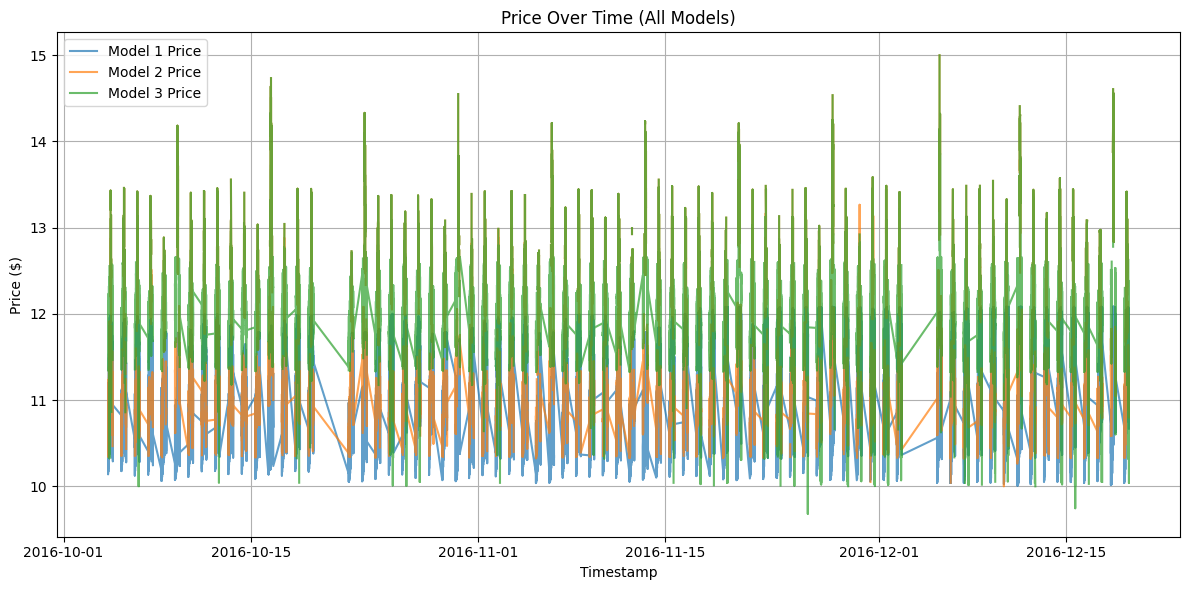

In [27]:
# Visualization
# Simple matplotlib plot to validate trends (Bokeh will be used in notebook)
plt.figure(figsize=(12, 6))
plt.plot(df['Timestamp'], df['Price_Model1'], label='Model 1 Price', alpha=0.7)
plt.plot(df['Timestamp'], df['Price_Model2'], label='Model 2 Price', alpha=0.7)
plt.plot(df['Timestamp'], df['Price_Model3'], label='Model 3 Price', alpha=0.7)
plt.legend()
plt.title('Price Over Time (All Models)')
plt.xlabel('Timestamp')
plt.ylabel('Price ($)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
# Prepare for Streaming
# Aggregate average price per day
df['Date'] = df['Timestamp'].dt.date
daily = df.groupby('Date')[['Price_Model1', 'Price_Model2', 'Price_Model3']].mean().reset_index()

# Create Bokeh Plot
source = ColumnDataSource(data=dict(Date=[], Price1=[], Price2=[], Price3=[]))

p = bokeh.plotting.figure(x_axis_type="datetime", title="Simulated Daily Dynamic Prices",
                          height=400, width=800)
p.line(x='Date', y='Price1', source=source, color='green', legend_label="Model 1")
p.line(x='Date', y='Price2', source=source, color='blue', legend_label="Model 2")
p.line(x='Date', y='Price3', source=source, color='red', legend_label="Model 3")
p.circle(x='Date', y='Price3', source=source, size=5, color='red')

p.add_tools(HoverTool(tooltips=[("Date", "@Date{%F}"), ("Model 1", "@Price1"),
                                ("Model 2", "@Price2"), ("Model 3", "@Price3")],
                      formatters={'@Date': 'datetime'}))
p.legend.location = "top_left"

In [29]:
# Real-Time Streaming Simulation

def stream_data():
    for i in range(len(daily)):
        new_row = {
            'Date': [pd.to_datetime(daily.loc[i, 'Date'])],
            'Price1': [daily.loc[i, 'Price_Model1']],
            'Price2': [daily.loc[i, 'Price_Model2']],
            'Price3': [daily.loc[i, 'Price_Model3']]
        }
        source.stream(new_row, rollover=30)
        time.sleep(1.5)  # Simulate delay like real-time stream

# Run simulation in background
threading.Thread(target=stream_data, daemon=True).start()


In [31]:
# Show the Bokeh plot using Panel
pn.Column(p).servable()

Column
    [0] Bokeh(figure)